# The results plot in the paper.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import kepler_kinematics as kek

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import gridspec
from scipy.stats import multivariate_normal

plotpar = {'axes.labelsize': 20,
                  'font.size': 12,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 15,
                  'ytick.labelsize': 15,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data file.

In [3]:
# df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")
# df["r_med_photogeo"] = df.r_est.values
# df.to_csv("../kepler_kinematics/gaia_kepler_lamost.csv")
df = pd.read_csv("../data/data.csv")

Load the results file.

In [4]:
# results = pd.read_csv("../data/all_kepler.csv")
# results = pd.read_csv("../data/all_kepler2.csv")
# results = pd.read_csv("../data/all_kepler3.csv")
# results = pd.read_csv("../data/all_kepler4.csv")
results = pd.read_csv("../data/edr3_all.csv")

In [5]:
results

,Unnamed: 0,Unnamed: 0.1,kepid,vx_inferred,vx_inferred_errp,vx_inferred_errm,vx_inferred_err,vx_random,vy_inferred,vy_inferred_errp,...,vxvx_covar,vxvy_covar,vxvz_covar,vxlnd_covar,vyvy_covar,vyvz_covar,vylnd_covar,vzvz_covar,vzlnd_covar,lndlnd_covar
0,0,0,9146069,-4.192027,4.134748,4.097635,4.099779,-2.702089,225.633943,17.068794,...,16.812393,70.142076,20.267188,-0.002114,293.217373,84.703179,0.000485,24.475601,-0.000231,0.000183
1,0,0,12013069,7.415093,2.301856,2.347991,2.362631,11.442605,225.533081,16.870616,...,5.583421,40.759011,11.332308,0.000087,297.635827,82.751965,0.001270,23.009151,0.000296,0.000035
2,0,0,3654753,106.275842,7.028382,6.860947,6.911196,101.268304,207.914373,17.610588,...,47.776575,101.533885,21.051589,0.140514,322.589392,51.862530,-0.025561,9.794237,0.040436,0.001402
3,0,0,11758292,35.189970,2.861134,2.873946,2.825292,38.978990,243.377744,17.273609,...,7.984270,47.270417,13.447582,0.023116,297.853042,89.574375,0.018220,28.285234,-0.028814,0.000898
4,0,0,11416572,118.920538,5.135817,5.164468,5.139557,120.372615,236.893996,19.007508,...,26.421652,48.065789,0.057036,0.190878,357.929442,70.229611,0.037171,18.263797,-0.080295,0.001742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,9965354,67.820866,3.357415,3.362778,3.423858,66.214758,222.182388,18.567033,...,11.725733,57.073589,10.532758,0.038307,347.529361,65.098106,-0.008179,12.224532,-0.004204,0.000675
4996,0,0,8126505,83.348666,4.001359,4.118476,4.133366,79.049834,218.093038,18.349976,...,17.088986,68.516678,9.655677,0.050547,348.586488,45.244022,0.015517,6.052608,0.012053,0.000627
4997,0,0,3448927,6.920421,6.016374,5.811567,5.980926,1.566167,221.795475,17.958910,...,35.780417,107.237836,18.770641,0.000053,321.427839,56.258627,-0.000169,9.856118,0.000644,0.000062
4998,0,0,7678547,-11.793144,4.720303,4.774335,4.766597,-18.989107,228.790231,17.771653,...,22.726133,85.270541,20.676404,-0.005419,321.392825,77.724370,-0.002787,18.835651,-0.003323,0.000230


Merge

In [6]:
adf = pd.merge(df, results, on="kepid", how="right")

In [7]:
def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

Define variables for plotting

In [8]:
box = 200

# lnD = np.log(df.r_est.values * 1e-3)
lnD = np.log(df.r_med_photogeo.values * 1e-3)
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx, vy, vz, lnD = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]

vx_c, vy_c, vz_c = adf.vx_inferred.values, adf.vy_inferred.values, adf.vz_inferred.values
lnD_c = adf.lndistance_inferred.values
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

alpha, ms, lw, lalpha = .4, 2, 3, 1.
color = "k" #lightseagreen"
cmap = "viridis_r"
vmin, vmax = 0, .1

In [9]:
mu, cov = kek.get_prior()
print(np.shape(cov), np.shape(mu))

(4, 4) (4,)


In [10]:
# mu = np.array([1.90239686e+01, 2.26487927e+02, -1.61060773e-01, -5.67645722e-01])
# cov = np.array([[ 9.19892667e+02, 3.59873515e+01, 4.17872508e+00, 5.84859558e+00],
#                 [ 3.59873515e+01, 3.48430979e+02, 1.59690824e+01, -1.19066196e+00],
#                 [ 4.17872508e+00, 1.59690824e+01, 1.56520350e+02, -7.16569183e-02],
#                 [ 5.84859558e+00, -1.19066196e+00, -7.16569183e-02, 3.90627246e-01]])

# mu = np.array([3.28608956e+01, 2.23269808e+02, 4.15032710e-02, -8.62313150e-02])
# cov = np.array([[1.85544780e+03, -9.46664808e+01, -2.76317476e+01, 1.24170994e+01],
#                 [-9.46664808e+01, 6.01848095e+02, 1.75608323e+01, -3.12163991e+00],
#                 [-2.76317476e+01, 1.75608323e+01, 3.34321276e+02, -1.75443452e-01],
#                 [1.24170994e+01, -3.12163991e+00, -1.75443452e-01, 4.60081725e-01]])

In [11]:
mvn = multivariate_normal(mu, cov)
p = mvn.pdf(np.vstack((vx_c, vy_c, vz_c, lnD_c)).T)

In [12]:
# Scatter parameters
vy_scatter = vy_c + np.random.randn(len(vy_c))*adf.vy_inferred_err.values
vz_scatter = vz_c + np.random.randn(len(vz_c))*adf.vz_inferred_err.values
vx_scatter = vx_c + np.random.randn(len(vx_c))*adf.vx_inferred_err.values
lnD_scatter = lnD_c + np.random.randn(len(lnD_c))*adf.lndistance_inferred_err.values

f = np.isfinite(adf.vx_random.values) & np.isfinite(adf.vy_random.values) & np.isfinite(adf.vz_random.values) \
    & np.isfinite(adf.lndistance_random.values)
vx_scatter, vy_scatter, vz_scatter, lnD_scatter = adf.vx_random.values[f], adf.vy_random.values[f], \
    adf.vz_random.values[f], adf.lndistance_random.values[f]

p = mvn.pdf(np.vstack((vx_scatter, vy_scatter, vz_scatter, lnD_scatter)).T)

In [13]:
# fig = plt.figure(figsize=(16, 12), dpi=200)

# nbins = 30

# # Vx
# axx = fig.add_subplot(441)
# H, bins = np.histogram(vx_scatter, nbins+20, density=True)
# axx.step(bins[:-1], H, color="k", label="$\mathrm{Without~RVs}$")
# H, bins = np.histogram(vx, nbins+20, density=True)
# axx.step(bins[:-1], H, zorder=0, color=".7", label="$\mathrm{With~RVs}$")
# xs = np.linspace(bins[0], bins[-1], 100)
# axx.plot(xs, gauss(xs, mu[0], np.sqrt(cov[0, 0])), label="$\mathrm{Prior}$")
# axx.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
# axx.set_ylabel("$\mathrm{N~stars}$")
# axx.set_xlim(-250, 250)
# plt.legend(bbox_to_anchor=(1.1, 1))


# # Vx Vy
# ax0 = fig.add_subplot(445, sharex=axx)
# # ax0 = fig.add_subplot(231)
# # ax0.plot(vx, vy, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax0.plot(vx_c, vy_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax0.scatter(vx_c, vy_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax0.scatter(vx_scatter, vy_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax0.plot(vx_scatter, vy_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
# confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, lw=2, edgecolor="w", zorder=2, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=1, lw=1, edgecolor="w", zorder=2, alpha=lalpha)
# # plt.colorbar(cb)
# ax0.set_ylim(ylim)
# ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
# ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

# # Vy
# axy = fig.add_subplot(446)
# H, bins = np.histogram(vy_scatter, nbins, density=True)
# xs = np.linspace(100, 350, 100)
# axy.plot(xs, gauss(xs, mu[1], np.sqrt(cov[1, 1])))
# axy.step(bins[:-1], H, color="k")
# H, bins = np.histogram(vy, 90, density=True)
# axy.step(bins[:-1], H, zorder=0, color=".7")
# axy.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
# axy.set_ylabel("$\mathrm{N~stars}$")
# axy.set_xlim(100, 350)

# # Vx Vz
# # ax1 = fig.add_subplot(232)
# ax1 = fig.add_subplot(449, sharex=axx)
# # ax1.plot(vx, vz, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax1.plot(vx_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax1.scatter(vx_c, vz_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax1.scatter(vx_scatter, vz_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax1.plot(vx_scatter, vz_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
# confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, lw=2, edgecolor="w", zorder=2, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=1, lw=1, edgecolor="w", zorder=2, alpha=lalpha)
# ax1.set_xlim(xlim)
# ax1.set_ylim(zlim)
# ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
# ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

# # Vx lnD
# # ax3 = fig.add_subplot(234)
# ax3 = fig.add_subplot(4,4,13, sharex=axx)
# # ax3.plot(vx, lnD, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax3.plot(lnD_c, vx_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax3.scatter(vx_c, lnD_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax3.scatter(vx_scatter, lnD_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax3.plot(vx_scatter, lnD_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[0, 0], cov[0, 3]], [cov[3, 0], cov[3, 3]]])
# confidence_ellipse_mod(vx_c, lnD_c, _cov, ax3, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, lnD_c, _cov, ax3, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, lnD_c, _cov, ax3, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vx_c, lnD_c, _cov, ax3, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
# ax3.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
# ax3.set_ylabel("$\mathrm{\ln(D/kpc)}$")
# ax3.set_ylim(dlim)
# ax3.set_xlim(xlim)

# #Vy Vz
# # ax2 = fig.add_subplot(233)
# ax2 = fig.add_subplot(4,4,10, sharex=axy)
# # ax2.plot(vy, vz, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax2.plot(vy_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax2.scatter(vy_c, vz_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax2.scatter(vy_scatter, vz_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax2.plot(vy_scatter, vz_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
# confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
# ax2.set_ylim(zlim)
# ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
# ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

# # Vz
# axz = fig.add_subplot(4,4,11)
# H, bins = np.histogram(vz_scatter, nbins, density=True)
# xs = np.linspace(-100, 100, 100)
# axz.plot(xs, gauss(xs, mu[2], np.sqrt(cov[2, 2])))
# axz.step(bins[:-1], H, color="k")
# H, bins = np.histogram(vz, nbins+20, density=True)
# axz.step(bins[:-1], H, zorder=0, color=".7")
# axz.set_xlabel("$\mathrm{V_z~[kms^{-1}]}$")
# axz.set_ylabel("$\mathrm{N~stars}$")
# axz.set_xlim(-100, 100)

# # Vy lnD
# ax4 = fig.add_subplot(4,4,14, sharex=axy)
# # ax4.plot(vy, lnD, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax4.plot(lnD_c, vy_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax4.scatter(vy_c, lnD_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax4.scatter(vy_scatter, lnD_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax4.plot(vy_scatter, lnD_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[1, 1], cov[1, 3]], [cov[3, 1], cov[3, 3]]])
# confidence_ellipse_mod(vy_c, lnD_c, _cov, ax4, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, lnD_c, _cov, ax4, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, lnD_c, _cov, ax4, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vy_c, lnD_c, _cov, ax4, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
# ax4.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
# ax4.set_ylabel("$\mathrm{\ln(D/kpc)}$")
# ax4.set_ylim(dlim)

# # Vz lnD
# ax5 = fig.add_subplot(4,4,15, sharex=axz)
# # ax5.plot(vz, lnD, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# # ax5.plot(lnD_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
# # cb=ax5.scatter(vz_c, lnD_c, c=p, s=2, rasterized=True, zorder=1)
# # cb=ax5.scatter(vz_scatter, lnD_scatter, c=p, s=2, rasterized=True, zorder=1)
# ax5.plot(vz_scatter, lnD_scatter, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# _cov = np.array([[cov[2, 2], cov[2, 3]], [cov[3, 2], cov[3, 3]]])
# confidence_ellipse_mod(vz_c, lnD_c, _cov, ax5, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vz_c, lnD_c, _cov, ax5, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vz_c, lnD_c, _cov, ax5, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
# confidence_ellipse_mod(vz_c, lnD_c, _cov, ax5, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
# ax5.set_xlabel("$\mathrm{V_z~[kms^{-1}]}$")
# ax5.set_ylabel("$\mathrm{\ln(D/kpc)}$")
# ax5.set_ylim(dlim)

# # lnD
# axD = fig.add_subplot(4,4,16)
# H, bins = np.histogram(lnD_scatter, nbins, density=True)
# axD.step(bins[:-1], H, color="k")
# xs = np.linspace(bins[0], bins[-1], 100)
# axD.plot(xs, gauss(xs, mu[3], np.sqrt(cov[3, 3])))
# H, bins = np.histogram(lnD, nbins, density=True)
# axD.step(bins[:-1], H, zorder=0, color=".7")
# axD.set_xlabel("$\mathrm{ln(D/kpc)}$")
# axD.set_ylabel("$\mathrm{N~stars}$")

# # plt.tight_layout()
# plt.subplots_adjust(hspace=.4, wspace=.45)
# plt.savefig("../plots/results")
# plt.savefig("../paper/results.pdf")

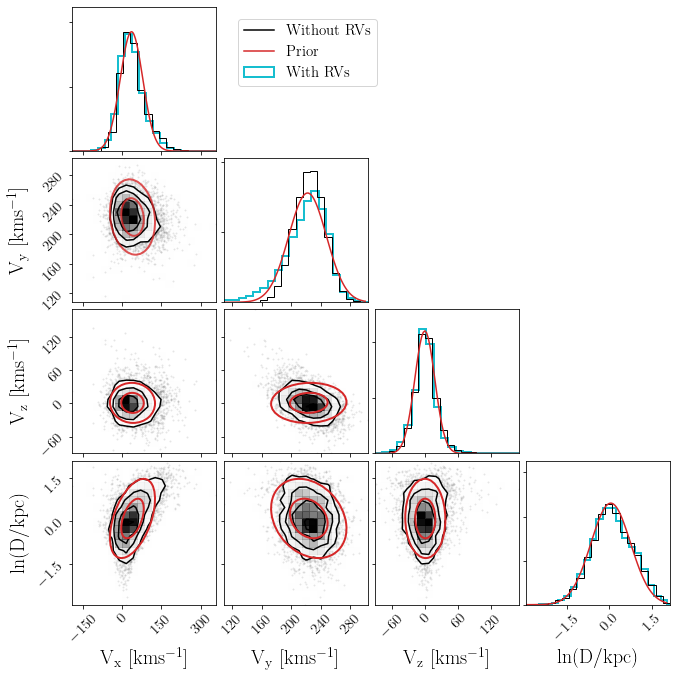

In [17]:
import corner
nbins = 30
color, zorder, color2 = "C3", 10, "C9"

labels = ["$\mathrm{V_x~[kms^{-1}]}$", "$\mathrm{V_y~[kms^{-1}]}$",
          "$\mathrm{V_z~[kms^{-1}]}$", "$\mathrm{\ln(D/kpc)}$"]
figure = corner.corner(np.array(
    [vx_scatter, vy_scatter, vz_scatter,lnD_scatter]
    ).T, labels=labels, hist_kwargs=dict({"density": True}), dpi=200);

# Extract the axes
ndim = 4
axes = np.array(figure.axes).reshape((ndim, ndim))

# Vx
axx = axes[0, 0]
H, bins = np.histogram(vx, nbins, density=True)
axx.hist(vx, 85, histtype="step", density=True, color=color2, zorder=0, lw=2, label="$\mathrm{With~RVs}$")
axx.plot([0, 0], [0, 0], "k-", label="$\mathrm{Without~RVs}$")
xs = np.linspace(bins[0], bins[-1], 1000)
axx.plot(xs, gauss(xs, mu[0], np.sqrt(cov[0, 0])), color=color, label="$\mathrm{Prior}$")
ylim = axx.get_ylim()
axx.set_ylim(ylim[0], ylim[1]*1.1)
axx.legend(bbox_to_anchor=(1.1, .4))

# Vy
axy = axes[1, 1]
H, bins = np.histogram(vy, 120, density=True)
# axy.step(bins[:-1], H, zorder=0, color=color2)
axy.hist(vy, 95, histtype="step", density=True, color=color2, zorder=0, lw=2)
xs = np.linspace(100, 300, 100)
axy.plot(xs, gauss(xs, mu[1], np.sqrt(cov[1, 1])), color=color)

# Vz
axz = axes[2, 2]
H, bins = np.histogram(vz, 200, density=True)
# axz.step(bins[:-1], H, zorder=0, color=color2)
axz.hist(vz, 110, histtype="step", density=True, color=color2, zorder=0, lw=2)
xs = np.linspace(-100, 200, 100)
axz.plot(xs, gauss(xs, mu[2], np.sqrt(cov[2, 2])), color=color)
ylim = axz.get_ylim()
axz.set_ylim(ylim[0], ylim[1]*1.1)

# lnD
axd = axes[3, 3]
H, bins = np.histogram(lnD, 30, density=True)
# axd.step(bins[:-1], H, zorder=0, color=color2)
axd.hist(lnD, 25, histtype="step", density=True, color=color2, zorder=0, lw=2)
xs = np.linspace(-3, 2, 100)
axd.plot(xs, gauss(xs, mu[3], np.sqrt(cov[3, 3])), color=color)
ylim = axd.get_ylim()
axd.set_ylim(ylim[0], ylim[1]*1.3)

# Vx Vy
axxy = axes[1, 0]
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, axxy, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=.8)
confidence_ellipse_mod(vx_c, vy_c, _cov, axxy, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=.8)

# Vx Vz
axxz = axes[2, 0]
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, axxz, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=lalpha)
confidence_ellipse_mod(vx_c, vz_c, _cov, axxz, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=lalpha)

# Vx lnD
axxd = axes[3, 0]
_cov = np.array([[cov[0, 0], cov[0, 3]], [cov[3, 0], cov[3, 3]]])
confidence_ellipse_mod(vx_c, lnD_c, _cov, axxd, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=lalpha)
confidence_ellipse_mod(vx_c, lnD_c, _cov, axxd, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=lalpha)


# Vy Vz
axyz = axes[2, 1]
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, axyz, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=lalpha)
confidence_ellipse_mod(vy_c, vz_c, _cov, axyz, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=lalpha)

# Vy lnD
axyd = axes[3, 1]
_cov = np.array([[cov[1, 1], cov[1, 3]], [cov[3, 1], cov[3, 3]]])
confidence_ellipse_mod(vy_c, lnD_c, _cov, axyd, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=lalpha)
confidence_ellipse_mod(vy_c, lnD_c, _cov, axyd, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=lalpha)

# Vy lnD
axzd = axes[3, 2]
_cov = np.array([[cov[2, 2], cov[2, 3]], [cov[3, 2], cov[3, 3]]])
confidence_ellipse_mod(vz_c, lnD_c, _cov, axzd, n_std=2, lw=2, edgecolor=color, zorder=10, alpha=lalpha)
confidence_ellipse_mod(vz_c, lnD_c, _cov, axzd, n_std=1, lw=2, edgecolor=color, zorder=10, alpha=lalpha)

plt.savefig("../plots/results")
plt.savefig("../paper/results.pdf")

In [ ]:
test_data = np.random.randn(1000)
plt.hist(test_data)
_h, _b = np.histogram(test_data)

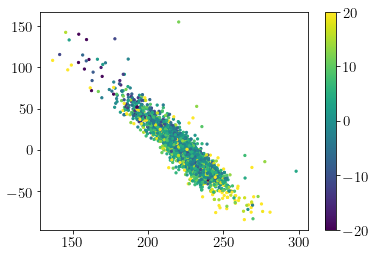

In [53]:
plt.scatter(adf.vy_inferred.values, adf.vz_inferred.values, c=adf.vz_inferred.values-adf.vz.values, s=5, vmin=-20, vmax=20)
# plt.scatter(adf.vy_inferred.values, adf.vz_inferred.values, c=adf.vy_inferred.values-adf.vy.values, s=5, vmin=-100, vmax=100)

plt.colorbar()

In [56]:
def resid_plot(vx, vy, vz, vx_inferred, vy_inferred, vz_inferred, vx_inferred_err, vy_inferred_err, vz_inferred_err,
               r_est, lndistance_inferred, p, vmin=100, vmax=300,
               ms=2, alpha=.1, box_size=150):

    fig = plt.figure(figsize=(16, 6), dpi=200)
#     gs = gridspec.GridSpec(2, 3, hspace=.0, wspace=.3, height_ratios=[1, 1])
    gs = gridspec.GridSpec(2, 4, hspace=.0, wspace=.4, height_ratios=[1, 1])

    ax0 = plt.subplot(gs[0, 0])
    xlims = (np.median(vx) - box_size, np.median(vx_inferred) + box_size)
    ax0.scatter(vx, vx_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    xs = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax0.set_ylim(xlims)
    ax0.set_xlim(xlims)
#     ax0.set_ylabel("$\mathrm{V_x~inferred~[kms^{-1}]}$")
    ax0.set_xticklabels([])

    ax1 = plt.subplot(gs[0, 1])
    ylims = (np.median(vy) - box_size, np.median(vy_inferred) + box_size)
    ax1.scatter(vy, vy_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    xs = np.linspace(ylims[0], ylims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax1.set_xlim(ylims)
    ax1.set_ylim(ylims)
#     ax1.set_ylabel("$\mathrm{V_y~inferred~[kms^{-1}]}$")
    ax1.set_xticklabels([])

    ax2 = plt.subplot(gs[0, 2])
    zlims = (np.median(vz) - box_size, np.median(vz_inferred) + box_size)
    ax2.scatter(vz, vz_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    xs = np.linspace(zlims[0], zlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax2.set_xlim(zlims)
    ax2.set_ylim(zlims)
#     ax2.set_ylabel("$\mathrm{V_z~inferred~[kms^{-1}]}$");
    ax2.set_xticklabels([])

    ax6 = plt.subplot(gs[0, 3])
    ax6.scatter(r_est, lndistance_inferred, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(min(lndistance_inferred), max(lndistance_inferred), 100)
    ax6.plot(xs, xs, "k", ls="--", zorder=1)
    
    # Residual panels
    # ---------------------------------------------------------------------------------------------------
    
    ax3 = plt.subplot(gs[1, 0])
    ax3.scatter(vx, vx_inferred - vx, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    ax3.errorbar(np.median(vx - 40), -30, yerr=np.median(vx_inferred_err), fmt="k.", label="$\mathrm{Typical~uncertainty}$")
    ax3.axhline(0, color="k", ls="--", zorder=1)
    ax3.set_ylim(-box_size, box_size)
    ax3.set_xlim(xlims)
    ax3.set_xlabel("$\mathrm{V_x~true~[kms^{-1}]}$")
#     ax3.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")
    ax3.legend()

    ax4 = plt.subplot(gs[1, 1])
    ax4.scatter(vy, vy_inferred - vy, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    ax4.errorbar(np.median(vy - 40), -30, yerr=np.median(vy_inferred_err), fmt="k.")
    ax4.axhline(0, color="k", ls="--", zorder=1)
    ax4.set_ylim(-box_size, box_size)
    ax4.set_xlim(ylims)
    ax4.set_xlabel("$\mathrm{V_y~true~[ks^{-1}]}$")
#     ax4.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")

    ax5 = plt.subplot(gs[1, 2])
    ax5.scatter(vz, vz_inferred - vz, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    ax5.errorbar(np.median(vz - 40), -30, yerr=np.median(vz_inferred_err), fmt="k.")
    print("typical vz uncertainty = ", np.median(vz_inferred_err), np.median(vz_inferred_err/vz)*100)
    ax5.axhline(0, color="k", ls="--", zorder=1)
    ax5.set_ylim(-box_size, box_size)
    ax5.set_xlim(zlims)
    ax5.set_xlabel("$\mathrm{V_z~true~[ks^{-1}]}$")
#     ax5.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")

    ax6 = plt.subplot(gs[1, 3])
    ax6.scatter(r_est, lndistance_inferred-r_est, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0, vmin=vmin, vmax=vmax)
    ax6.axhline(0, color="k", ls="--", zorder=1)
    ax6.set_ylim(-.5, .5)
        
    return fig

typical vz uncertainty =  5.074652077947949 6.752405527482147


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


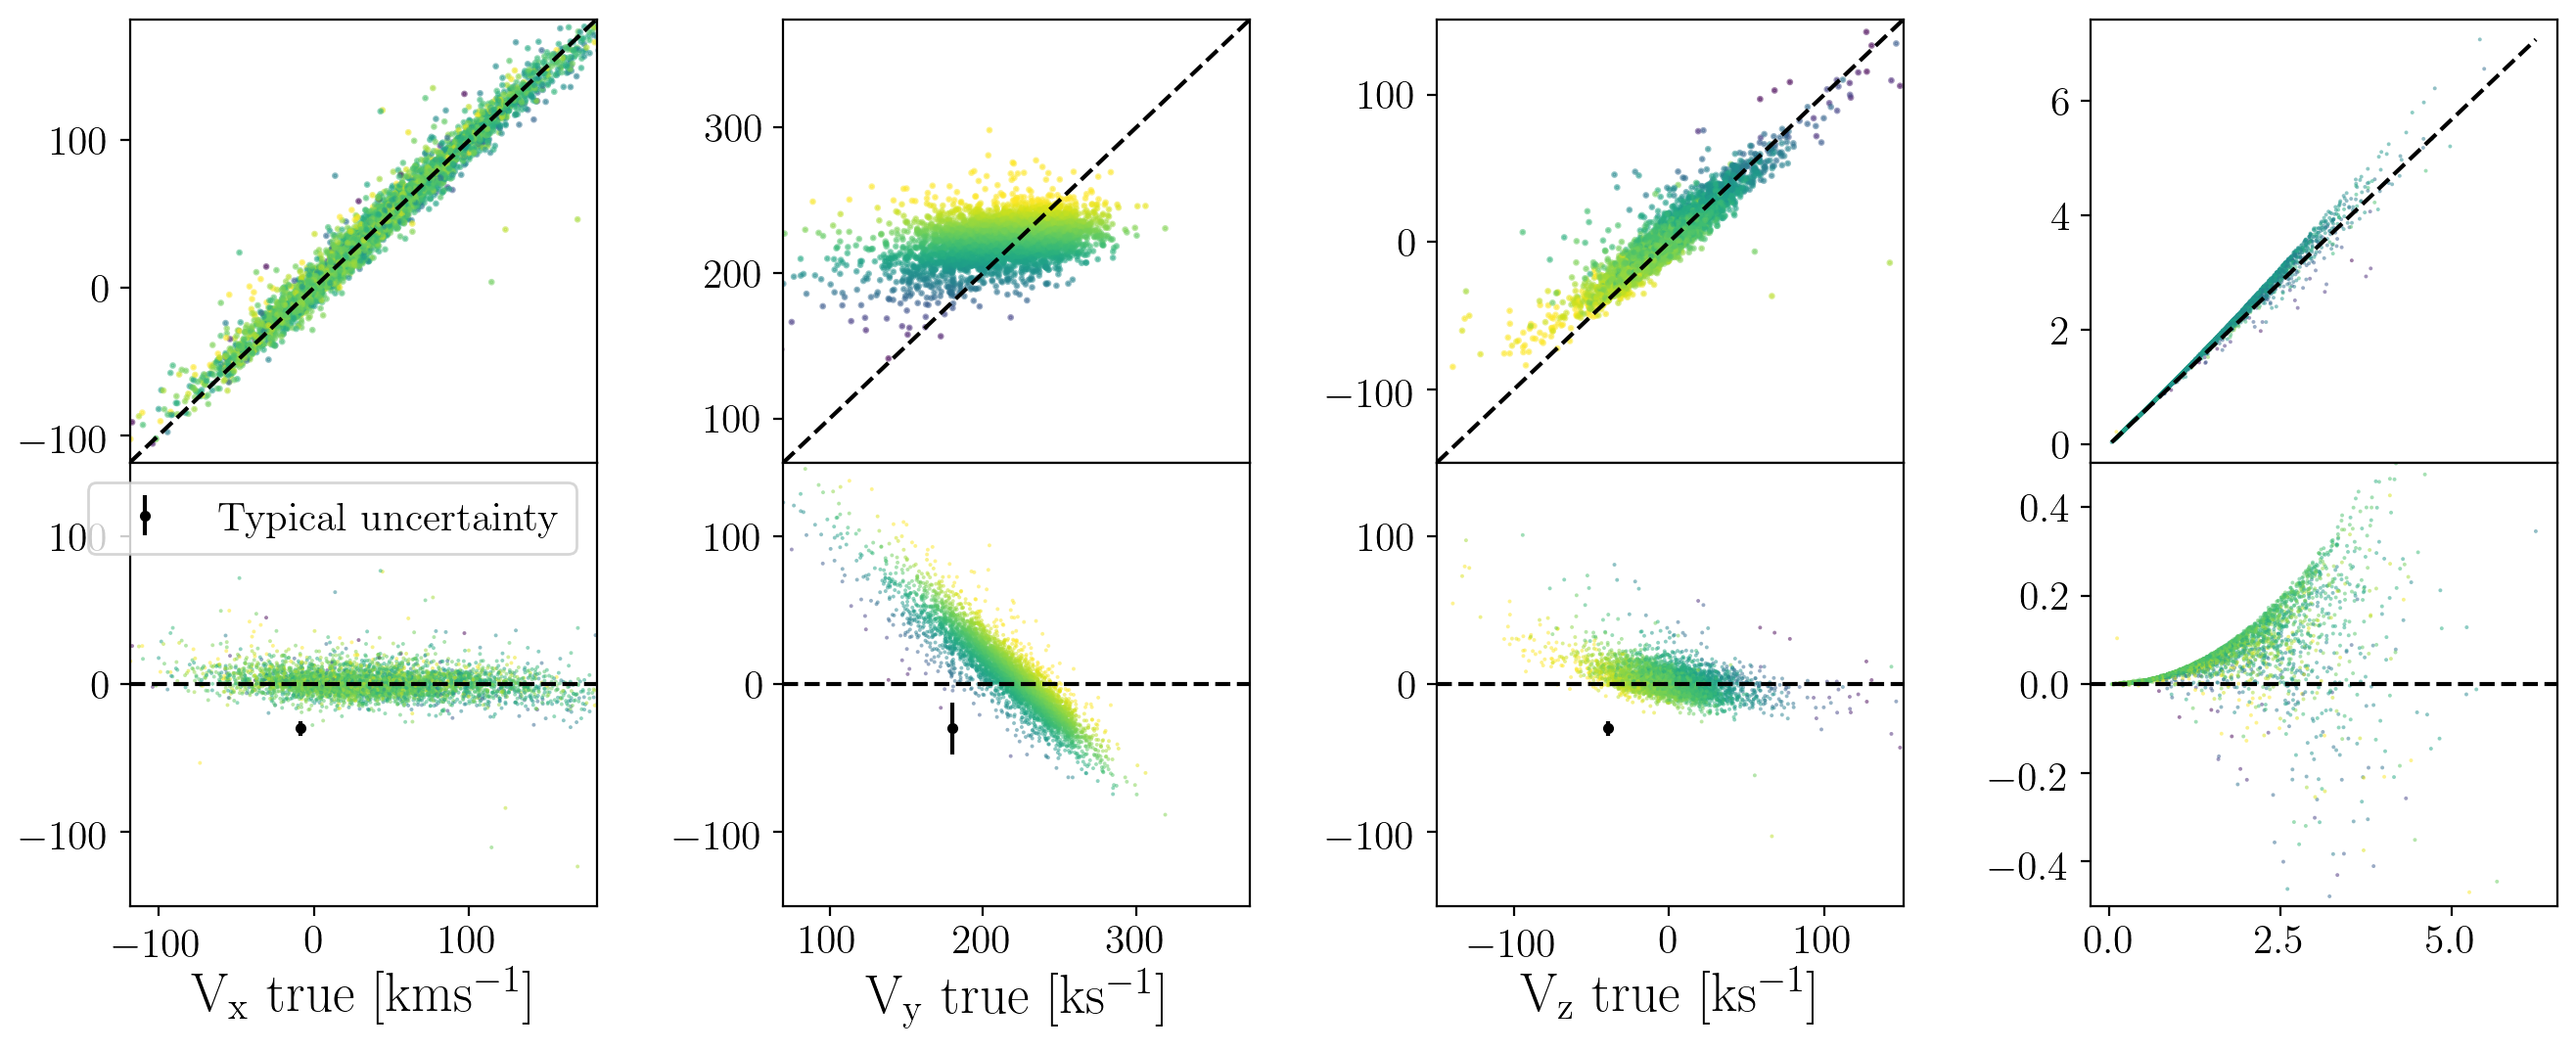

In [59]:
m = np.isfinite(adf.vx.values) & np.isfinite(adf.vy.values) & np.isfinite(adf.vz.values)
fig = resid_plot(adf.vx.values[m], adf.vy.values[m], adf.vz.values[m], adf.vx_inferred.values[m],
                 adf.vy_inferred.values[m], adf.vz_inferred.values[m], adf.vx_inferred_err.values[m],
                 adf.vy_inferred_err.values[m], adf.vz_inferred_err.values[m],
                 adf.r_est.values[m]*1e-3, np.exp(adf.lndistance_inferred.values[m]),
                 adf.vy_inferred.values[m], alpha=.5, vmin=150, vmax=250)#p[m], alpha=.5)

plt.tight_layout()

In [82]:
mu, cov = kek.get_prior()
print(np.shape(cov), np.shape(mu))

(4, 4) (4,)


In [80]:
cov

array([[ 1.85544780e+03, -9.46664808e+01, -2.76317476e+01,
         1.24170994e+01],
       [-9.46664808e+01,  6.01848095e+02,  1.75608323e+01,
        -3.12163991e+00],
       [-2.76317476e+01,  1.75608323e+01,  3.34321276e+02,
        -1.75443452e-01],
       [ 1.24170994e+01, -3.12163991e+00, -1.75443452e-01,
         4.60081725e-01]])

In [74]:
def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

223.269808 601.848095


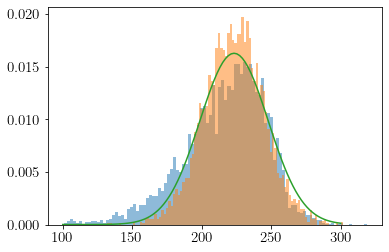

In [145]:
m = np.isfinite(adf.vy.values) & (adf.vy.values < 400) & (adf.vy.values > 100)
plt.hist(adf.vy.values[m], 100, density=True, alpha=.5);
plt.hist(vy_scatter[m], 100, density=True, alpha=.5);
# plt.hist(adf.vy_inferred.values[m], 100, density=True, alpha=.5);
xs = np.linspace(100, 300, 100)
plt.plot(xs, gauss(xs, mu[1], np.sqrt(cov[1, 1])))
print(mu[1], cov[1, 1])

In [55]:
from scipy.stats import multivariate_normal
mu, cov = np.array([0, 0]), np.array([[1, 0.5], [.5, 1]])
mvn = multivariate_normal(mu, cov)
x = np.random.randn(1000, 2)
p = mvn.pdf(x)

(-3, 3)

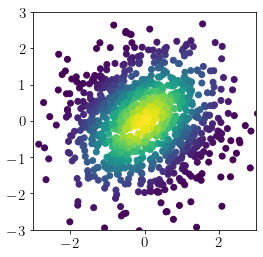

In [56]:
plt.figure(figsize=(4,4))
plt.scatter(x[:, 0], x[:, 1], c=p)
plt.xlim(-3, 3)
plt.ylim(-3, 3)